https://docs.langchain.com/oss/python/integrations/retrievers

# What are Retrievers

A retriever is a component in LangChain that fetches relevant documents from a data source in response to a user's query.

- There are multiple types of retrievers

- All retrievers in LangChain are runnables

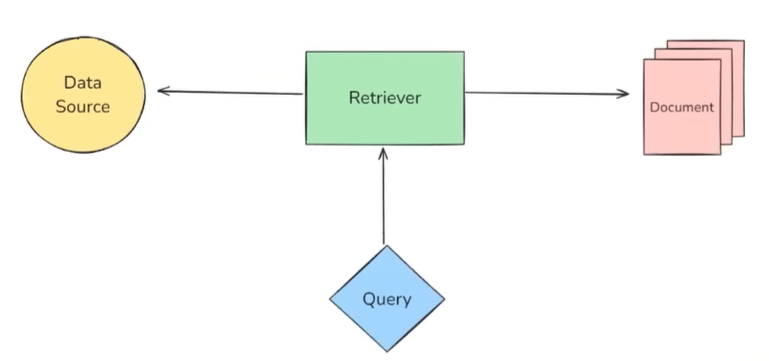

# Types of Retriever

## 1. Wikipedia Retriever

- A Wikipedia Retriever is a retriever that queries that Wikipedia API to fetch relevant content for a given query.

### How it Works
1. You give it a query (e.g., "Albert Einstein")
2. It sends the query to Wikipedia's API
3. It retrieves the **most relevant articles**
4. It returns them as LangChain `Document` Objects

In [4]:
from langchain_community.retrievers import WikipediaRetriever

In [18]:
# Initialize the retriever (optional: set language and top_k)
retriever = WikipediaRetriever(
    top_k_results=2,
    lang='en'

)

In [19]:
retriever

WikipediaRetriever(wiki_client=<module 'wikipedia' from 'D:\\ai\\ai-development\\.venv_ai_course\\Lib\\site-packages\\wikipedia\\__init__.py'>, top_k_results=2)

In [20]:
# Define Your query
query = "The Geopolitical history India and pakistan from the perspective of a chinese"

# get relevant Wikipedia documents
docs = retriever.invoke(query)

In [21]:
len(docs)

2

In [22]:
docs[0]

Document(metadata={'title': 'India–Pakistan war of 1971', 'summary': "The India–Pakistan war of 1971, also known as the third Indo-Pakistani war, was a military confrontation between India and Pakistan that occurred during the Bangladesh Liberation War in East Pakistan from 3 December 1971 until the Pakistani capitulation in Dhaka on 16 December 1971.  The war began with Pakistan's Operation Chengiz Khan, consisting of preemptive aerial strikes on eight Indian air stations. The strikes led to India declaring war on Pakistan, marking their entry into the war for East Pakistan's independence, on the side of Bengali nationalist forces. India's entry expanded the existing conflict with Indian and Pakistani forces engaging on both the eastern and western fronts.\nThirteen days after the war started, India achieved a clear upper hand, and the Eastern Command of the Pakistan military signed the instrument of surrender on 16 December 1971 in Dhaka, marking the formation of East Pakistan as the

In [23]:
for i, doc in enumerate(docs):
    print(f"\n--- Result {i + 1} ---")
    print(f"Content: \n {doc.page_content}...")


--- Result 1 ---
Content: 
 The India–Pakistan war of 1971, also known as the third Indo-Pakistani war, was a military confrontation between India and Pakistan that occurred during the Bangladesh Liberation War in East Pakistan from 3 December 1971 until the Pakistani capitulation in Dhaka on 16 December 1971.  The war began with Pakistan's Operation Chengiz Khan, consisting of preemptive aerial strikes on eight Indian air stations. The strikes led to India declaring war on Pakistan, marking their entry into the war for East Pakistan's independence, on the side of Bengali nationalist forces. India's entry expanded the existing conflict with Indian and Pakistani forces engaging on both the eastern and western fronts.
Thirteen days after the war started, India achieved a clear upper hand, and the Eastern Command of the Pakistan military signed the instrument of surrender on 16 December 1971 in Dhaka, marking the formation of East Pakistan as the new nation of Bangladesh. Approximately 9

## 2. Vector Store Retriever

- A Vector Store Retriever in LangChain is the most common type of retriever that lets you search and fetch documents from a vector store based on semantic similarity using vector embeddings.

### How it Works
1. You Store your documents in a **vector store** (like FAISS, Chroma, Weaviate)
2. Each Document is converted into a **dense vector** using an **embedding model**
3. When the user enters a query:
      - It's also turned into a vector
      - The retriever compares the query vector with the stored vectors
      - It retrieves the top-k most similar ones

In [28]:
from langchain_community.vectorstores import Chroma
from langchain_openai import OpenAIEmbeddings
from langchain_core.documents import Document
import os
from dotenv import load_dotenv

In [29]:
load_dotenv()

True

In [27]:
# Step 1: Your source documents
documents = [
    Document(page_content="LangChain helps developers build LLM applications easily."),
    Document(page_content="Chroma is a vector database optimized for LLM-based search."),
    Document(page_content="Embeddings convert text into high-dimensional vectors."),
    Document(page_content="OpenAI provides powerful embeddings models."),
]

In [30]:
# Step 2: Initilize embedding model
embedding_model = OpenAIEmbeddings(
    api_key=os.getenv("OPEN_AI_KEY"),
    base_url="https://openrouter.ai/api/v1",
    model="text-embedding-3-large",
)

In [33]:
# Step 3: Create Chroma Vector Store in Memory
vectorstore = Chroma.from_documents(
    documents=documents,
    embedding=embedding_model,
    collection_name="my_collection",
)

In [35]:
# Step 4: Convert vectorstore into a retriever
retriever = vectorstore.as_retriever(search_kwargs={"k": 2})

In [36]:
retriever

VectorStoreRetriever(tags=['Chroma', 'OpenAIEmbeddings'], vectorstore=<langchain_community.vectorstores.chroma.Chroma object at 0x000002442735F2D0>, search_kwargs={'k': 2})

In [37]:
query = "What is Chroma used for?"
results = retriever.invoke(query)

In [38]:
results

[Document(metadata={}, page_content='Chroma is a vector database optimized for LLM-based search.'),
 Document(metadata={}, page_content='LangChain helps developers build LLM applications easily.')]

In [39]:
for i, doc in enumerate(results):
    print(f"\n ---Result {i + 1} ---")
    print(doc.page_content)


 ---Result 1 ---
Chroma is a vector database optimized for LLM-based search.

 ---Result 2 ---
LangChain helps developers build LLM applications easily.


## 2. Maximal Marginal Relevance (MMR)

> "How can we pick results that are not only relevant to the query but also different from each other ?"

- MMR is an information retrieval algorithm designed to reduce redundancy in the retrieved results while maintaining high relevancy to the query.


### Why MMR retriever?
In regular similarity search, you may get documents that are:
 - All very similar to each other
 - repeating the same info
 - Lacking diverse perspectives

MMR Retriever avoids that by:
 - Picking the **most relevant document** first
 - Then Picking the next most relevant **and least similar** to already selected docs
 - And so on...

This helps especially in RAG pipelines where:
 - You want your context window to contain **diverse but still relevant information**
 - Especially useful when documents are semantically overlapping
   
 

In [43]:
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
import os
from dotenv import load_dotenv

In [44]:
load_dotenv()

True

In [40]:
# Sample documents
docs = [
    Document(page_content="LangChain makes it easy to work with LLMs."),
    Document(page_content="LangChain is used to build LLM based applications."),
    Document(page_content="Chroma is used to store and search document embeddings."),
    Document(page_content="Embeddings are vector representations of text."),
    Document(page_content="MMR helps you get diverse results when doing similarity search."),
    Document(page_content="LangChain supports Chroma, FAISS, Pinecone, and more."),
]

In [60]:
# Initialize openai embeddings

embedding_model = OpenAIEmbeddings(
    api_key=os.getenv("OPEN_AI_KEY"),
    model="text-embedding-3-large",
    base_url="https://openrouter.ai/api/v1",
)


In [61]:
# Step 2: Create the FAISS vector store from documents
vectorstore = FAISS.from_documents(
    documents=docs,
    embedding=embedding_model,
)

In [62]:
# Enable MMR in the retriever
retriever = vectorstore.as_retriever(
    search_type='mmr',         # this enables MMR
    search_kwargs={'k': 3, "lambda_mult": 0.5}   # k = top results, lambda_mult = relevance-diversity balance
)

In [63]:
query = "What is langchain ?"
results = retriever.invoke(query)

In [64]:
for i, doc in enumerate(results):
    print(f"\n--- Result {i+1} ---")
    print(doc.page_content)


--- Result 1 ---
LangChain is used to build LLM based applications.

--- Result 2 ---
Embeddings are vector representations of text.

--- Result 3 ---
LangChain supports Chroma, FAISS, Pinecone, and more.


# 3. Multi-Query Retriever

> Sometimes a single query might not capture all the ways information is phrased in you documents.

For example:
**Query**:
> **"How can I stay Healthy ?"**

Could you mean: 
 - What should I eat ?
 - How often should I exercise ?
 - How can I manage stress ?

A simple similarity search might **miss documents** that talk about those things but don't use the word "healthy."

1. **Takes your original query**
2. **Uses an LLM (e.g., GPT-3.5)** to generate multiple semantically different versions of that query
3. **Performs retrieval for each sub-query**
4. **Combines and deduplicates the results**

In [1]:
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_core.documents import Document
from langchain_openai import ChatOpenAI
from langchain.retrievers.multi_query import MultiQueryRetriever

ModuleNotFoundError: No module named 'langchain.retrievers'

In [2]:
# Relevant health & wellness documents
all_docs = [
    Document(page_content="Regular walking boosts heart health and can reduce symptoms of depression.", metadata={"source": "H1"}),
    Document(page_content="Consuming leafy greens and fruits helps detox the body and improve longevity.", metadata={"source": "H2"}),
    Document(page_content="Deep sleep is crucial for cellular repair and emotional regulation.", metadata={"source": "H3"}),
    Document(page_content="Mindfulness and controlled breathing lower cortisol and improve mental clarity.", metadata={"source": "H4"}),
    Document(page_content="Drinking sufficient water throughout the day helps maintain metabolism and energy.", metadata={"source": "H5"}),
    Document(page_content="The solar energy system in modern homes helps balance electricity demand.", metadata={"source": "I1"}),
    Document(page_content="Python balances readability with power, making it a popular system design language.", metadata={"source": "I2"}),
    Document(page_content="Photosynthesis enables plants to produce energy by converting sunlight.", metadata={"source": "I3"}),
    Document(page_content="The 2022 FIFA World Cup was held in Qatar and drew global energy and excitement.", metadata={"source": "I4"}),
    Document(page_content="Black holes bend spacetime and store immense gravitational energy.", metadata={"source": "I5"}),
]

In [3]:
# Initialize OpenAI embeddings
embedding_model = OpenAIEmbeddings()

# Create FAISS vector store
vectorstore = FAISS.from_documents(documents=all_docs, embedding=embedding_model)

OpenAIError: The api_key client option must be set either by passing api_key to the client or by setting the OPENAI_API_KEY environment variable

In [4]:
# Create retrievers
similarity_retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 5})

NameError: name 'vectorstore' is not defined

In [5]:
multiquery_retriever = MultiQueryRetriever.from_llm(
    retriever=vectorstore.as_retriever(search_kwargs={"k": 5}),
    llm=ChatOpenAI(model="gpt-3.5-turbo")
)

NameError: name 'MultiQueryRetriever' is not defined

In [6]:
# Query
query = "How to improve energy levels and maintain balance?"

In [7]:
# Retrieve results
similarity_results = similarity_retriever.invoke(query)
multiquery_results= multiquery_retriever.invoke(query)

NameError: name 'similarity_retriever' is not defined

In [8]:
for i, doc in enumerate(similarity_results):
    print(f"\n--- Result {i+1} ---")
    print(doc.page_content)

print("*"*150)

for i, doc in enumerate(multiquery_results):
    print(f"\n--- Result {i+1} ---")
    print(doc.page_content)

NameError: name 'similarity_results' is not defined

In [10]:
# OUTPUT

--- Result 1 ---
Drinking sufficient water throughout the day helps maintain metabolism and energy.

--- Result 2 ---
Mindfulness and controlled breathing lower cortisol and improve mental clarity.

--- Result 3 ---
Regular walking boosts heart health and can reduce symptoms of depression.

--- Result 4 ---
Deep sleep is crucial for cellular repair and emotional regulation.

--- Result 5 ---
The solar energy system in modern homes helps balance electricity demand.
******************************************************************************************************************************************************

--- Result 1 ---
Drinking sufficient water throughout the day helps maintain metabolism and energy.

--- Result 2 ---
Mindfulness and controlled breathing lower cortisol and improve mental clarity.

--- Result 3 ---
Regular walking boosts heart health and can reduce symptoms of depression.

--- Result 4 ---
Consuming leafy greens and fruits helps detox the body and improve longevity.

--- Result 5 ---
Deep sleep is crucial for cellular repair and emotional regulation.


SyntaxError: invalid syntax (3687203209.py, line 3)

# 4. Contextual Compression Retriever

The Contextual Compression Retriever in LangChain is an Advanced retriever that improves retrieval quality by compressing documents after retrieval - keeping only the relevant content based on the user's query

**Query:**
> "What is photosynthesis?"

**Retrieved Document (by a traditional retriever)**:
> "The Grand Canyon is a famous natural site.<br>
> Photosynthesis is how plant convert light into energy.<br>
> Many tourists visit every year."

**Problem**:
- The retriever returns the **entire paragraph**
- Only **one sentence** is actually relevant to the query
- The rest is **irrelecant noise** that wastes context window and may confuse the LLM

### How it Works
1. **Base Retriever** (e.g., FAISS, Chroma) retrieves N documents
2. A **compressor** (usually an LLM) is applied to each document.
3. The compressor keeps **only the parts relevant to the query**
4. Irrelevant content is discarded.

#### When to use
- Your Documents are **long and contain mixed information**
- You want to **reduce context length** for LLM.
- You need to **improve answer accuracy** in RAG pipelines

In [11]:
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings, ChatOpenAI
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain.retrievers.document_compressors import LLMChainExtractor
from langchain_core.documents import Document

ImportError: cannot import name 'ContextualCompressionRetriever' from 'langchain_core.retrievers' (D:\ai\ai-development\.venv_ai_course\Lib\site-packages\langchain_core\retrievers.py)

In [ ]:
# Recreate the document objects from the previous data
docs = [
    Document(page_content=(
        """The Grand Canyon is one of the most visited natural wonders in the world.
        Photosynthesis is the process by which green plants convert sunlight into energy.
        Millions of tourists travel to see it every year. The rocks date back millions of years."""
    ), metadata={"source": "Doc1"}),

    Document(page_content=(
        """In medieval Europe, castles were built primarily for defense.
        The chlorophyll in plant cells captures sunlight during photosynthesis.
        Knights wore armor made of metal. Siege weapons were often used to breach castle walls."""
    ), metadata={"source": "Doc2"}),

    Document(page_content=(
        """Basketball was invented by Dr. James Naismith in the late 19th century.
        It was originally played with a soccer ball and peach baskets. NBA is now a global league."""
    ), metadata={"source": "Doc3"}),

    Document(page_content=(
        """The history of cinema began in the late 1800s. Silent films were the earliest form.
        Thomas Edison was among the pioneers. Photosynthesis does not occur in animal cells.
        Modern filmmaking involves complex CGI and sound design."""
    ), metadata={"source": "Doc4"})
]

In [ ]:
# Create a FAISS vector store from the documents
embedding_model = OpenAIEmbeddings()
vectorstore = FAISS.from_documents(docs, embedding_model)

In [ ]:
base_retriever = vectorstore.as_retriever(search_kwargs={"k": 5})

In [ ]:
# Set up the compressor using an LLM
llm = ChatOpenAI(model="gpt-3.5-turbo")
compressor = LLMChainExtractor.from_llm(llm)

In [ ]:
# Create the contextual compression retriever
compression_retriever = ContextualCompressionRetriever(
    base_retriever=base_retriever,
    base_compressor=compressor
)

In [ ]:
# Query the retriever
query = "What is photosynthesis?"
compressed_results = compression_retriever.invoke(query)

In [ ]:
for i, doc in enumerate(compressed_results):
    print(f"\n--- Result {i+1} ---")
    print(doc.page_content)


In [12]:
# OUTPUT

--- Result 1 ---
Photosynthesis is the process by which green plants convert sunlight into energy.

--- Result 2 ---
The chlorophyll in plant cells captures sunlight during photosynthesis.


SyntaxError: invalid syntax (2434743917.py, line 3)